In [6]:
# Imports
## Import data preparation libraries
import pandas as pd 
import numpy as np 
from datetime import datetime

from optbinning import BinningProcess

##Import data enrichment library
import requests 

## Import database libraries 
from sqlalchemy import create_engine, Table, Column, Integer, String, Float, Boolean, Date, MetaData, ForeignKey
from sqlalchemy.orm import relationship, backref, sessionmaker
from sqlalchemy.ext.declarative import declarative_base

from locale import atof, setlocale, LC_NUMERIC, LC_ALL
setlocale(LC_ALL, 'fr_FR.UTF-8')

'fr_FR.UTF-8'

In [ ]:
# choix à faire sur l'architecture base de données :
## soit transactions(avec base maisons et base appartements), soit adresses
iter_csv= pd.read_csv("../data/valeursfoncieres-2021.txt", sep='|',iterator=True, chunksize=100000, low_memory = False)
df_maison = pd.concat([chunk[chunk['Code type local'] == 1] for chunk in iter_csv]) 
df_maison.info()

In [ ]:
#df_tot= pd.read_csv("../data/valeursfoncieres-2021.txt", sep='|', low_memory = False, nrows=10000)

In [1]:
import pandas as pd


class GetData:
    """ Read data from csv and load it in a dataframe
    accepted arguments : path to file , separator, chunksize and filter
    option to load csv by filtering on house type
    """

    def __init__(self,
                 path="../data/valeursfoncieres-2021.txt",
                 sep="|",
                 chunksize=100000):
        self.path = path
        self.sep = sep
        self.chunksize = chunksize

    def read_csv(self, filtering_column='Code type local', filter=1):
        """ pass option on which column to filter and filter value
        if several filter value, pass the as a list"""
        iter_csv = pd.read_csv(self.path,
                               sep=self.sep,
                               iterator=True,
                               chunksize=self.chunksize,
                               low_memory=False)
        self.df = pd.concat(
            [chunk[chunk[filtering_column].isin(filter)] for chunk in iter_csv])
        return self.df

    def enrichissement_coordinates(self, df):
        pass


In [ ]:
#df_tot[df_tot.index.isin([71,72,73,74])]

In [53]:
df2= GetData().read_csv(filter=[1,3])

In [ ]:
# code pour voir comment est rempli pythonpath
#import sys
#print(sys.path)

In [ ]:
#df2['Valeur fonciere']= df2['Valeur fonciere'].apply(lambda x: atof(x))

In [51]:
#from house_prediction_package.data import GetData
import pandas as pd
import numpy as np
from datetime import datetime
from more_itertools import chunked
from scipy import stats

from sklearn.model_selection import train_test_split

class Preprocessing :

    def __init__(self,df) :
        # self.df = get_data().read_csv()
        self.df = df

    def clean_columns(self,
                      columns=[
                          'Code service CH', 'Reference document',
                          '1 Articles CGI', '2 Articles CGI', '3 Articles CGI',
                          '4 Articles CGI', '5 Articles CGI', 'No Volume',
                          'Identifiant local'
                      ]):
        """ drop useless columns
        Customisation of columns to drop must be entered as a list
        """
        # suppression of 100% empty columns - these columns are officially not completed in this db
        self.df = self.df.drop(columns,axis=1)
        # suppression of columns poorly completed
        columns_to_drop = [column for column in self.df.columns if ((self.df[column].isnull().value_counts().sort_index()[0]/self.df.shape[0])*100) < 2 ]
        self.df= self.df.drop(columns_to_drop,axis=1)
        # suppression of nan value on target variable
        self.df= self.df.dropna(subset=['Valeur fonciere'])
        # pre processing avant groupby mais attention sortir valeures foncieres avant de mettre en POO
        ob_columns= self.df.dtypes[self.df.dtypes == 'O'].index
        num_columns= self.df.dtypes[self.df.dtypes == ''].index
        for column in ob_columns :
            self.df[column]=self.df[column].replace(np.nan,'',regex=True)
        #à adapter in v2
        self.df[[
                'Surface terrain', 'Surface reelle bati',
                'Nombre pieces principales', 'Surface Carrez du 1er lot'
        ]] = self.df[[
                'Surface terrain', 'Surface reelle bati',
                'Nombre pieces principales', 'Surface Carrez du 1er lot'
            ]].apply(pd.to_numeric, errors='coerce')
        #drop duplicates
        #self.df = self.df.drop_duplicates().reset_index(drop= True)
        # by returning self, we can do method chaining like preprocessing(df).clean_columns().create_identifier()
        return self

    def create_identifier(self) :
        """ Create a 'unique' identifier allowing us to group several lines corresponding to a unique transaction
        """
        variables_to_clean = [
            "Code departement", "Code commune", "Prefixe de section",
            "Section", "No plan"
            ]
        size_variables= [2,3,3,2,4]
        for i,j in zip(variables_to_clean,size_variables):
            chunked_data = chunked(self.df[i], 10000, strict=False)
            values = {"Prefixe de section": '000'}
            self.df= self.df.fillna(value=values)
            if i == "Prefixe de section" :
                self.df[i] = self.df[i].apply(str).apply(lambda x: x[:3])
            new_variable = [
                str(value).replace(".","").zfill(j) for sublist in list(chunked_data)
                for value in sublist
            ]
            self.df[f"clean_{i.replace(' ','_').lower()}"] = new_variable
            self.df= self.df.drop([i],axis=1)
        self.df["parcelle_cadastrale"] = self.df[[
            "clean_code_departement", "clean_code_commune", "clean_prefixe_de_section",
            "clean_section", "clean_no_plan"]].apply(lambda x: "".join(x), axis=1)
        self.df["parcelle_cad_section"]=self.df["parcelle_cadastrale"].str[:10]
        self.df = self.df.drop([
            "clean_prefixe_de_section", "clean_section", "clean_no_plan"
        ], axis = 1)
        return self

    def aggregate_transactions(self):
        self.df = self.df.groupby(["parcelle_cad_section","Date mutation","Valeur fonciere"], as_index= False).apply(lambda x : pd.Series({
            "B_T_Q" : x["B/T/Q"].max()
            ,"type_de_voie": x["Type de voie"].max()
            ,"voie": x["Voie"].max()
            ,"code_postal": x["Code postal"].max()
            ,"commune": max(x["Commune"])
            ,"clean_code_departement": x["clean_code_departement"].max()
            ,"clean_code_commune": max(x["clean_code_commune"])
            ,"surface_carrez_lot_1" :  x["Surface Carrez du 1er lot"].sum()/(x["Surface reelle bati"].count()/(x["Surface reelle bati"].count()/x["Nature culture"].nunique()))
            ,"Nb_lots": x[("Nombre de lots")].max()
            ,"surface_terrain" : x["Surface terrain"].sum()/(x["Surface terrain"].count()/x["Surface terrain"].nunique()) if int(x["Surface terrain"].nunique()) > 1 and int(x["Nature culture"].nunique()) >1 else x["Surface terrain"].max()
            ,"surface_reelle_bati" : x["Surface reelle bati"].sum()/(x["Surface reelle bati"].count()/(x["Surface reelle bati"].count()/x["Nature culture"].nunique()))
            ,"nb_pieces_principales" : x["Nombre pieces principales"].sum()/(x["Nombre pieces principales"].count()/(x["Surface reelle bati"].count()/x["Nature culture"].nunique()))
            ,"dependance" : x["Type local"].unique()
            ,"main_type_terrain" : x["Nature culture"].max()
            ,"parcelle_cadastrale": x["parcelle_cadastrale"].max()}))
        #drop rows with only dependances transactions as we focus on houses
        self.df = self.df[self.df.dependance.apply(
            lambda x: x.all() != "Dépendance")].reset_index(drop=True)
        self.df["dependance"] = self.df.dependance.apply(sorted, 1)
        self.df[["Dependance",
                 "Maison"]] = pd.DataFrame(self.df.dependance.tolist(),
                                           index=self.df.index)
        self.df["Dependance"] = [1 if value =="Dépendance"else 0 for value in self.df["Dependance"]]
        self.df= self.df.drop(["dependance","Maison"],axis =1)
        return self.df

    # to do : function calling enrichissement from data


    def feature_generation (self):
        # convert the 'Date' column to datetime format
        self.df["month"] = pd.to_datetime(
            self.df["Date mutation"],format="%d/%m/%Y").dt.month
        self.df= self.df.drop(["Date mutation"], axis = 1)
        ## attention à ne faire qu'après avoir enrichi avec variables insee
        dict_type_voie = dict()
        for value in self.df["type_de_voie"].value_counts()[self.df["type_de_voie"].value_counts()<300 ].index.values :
            dict_type_voie[value] = "Autres"
        self.df=self.df.replace({"type_voie" : dict_type_voie})
        self.df["type_de_voie"]= self.df["type_de_voie"].replace(np.nan,'vide')
        return self

    def zscore (self) :
        # Calculate the z-score from scratch
        self.df['Valeur fonciere']= df['Valeur fonciere'].apply(lambda x: atof(x))
        standard_deviation = self.df["Valeur fonciere"].std(ddof=0)
        mean_value = self.df["Valeur fonciere"].mean()
        zscores = [(value - mean_value) / standard_deviation
                for value in self.df["Valeur fonciere"]]
        self.df["zscores"]= zscores
        # absolute value of zscore and if sup x then 1  :
        self.df["outlier"] = (abs(self.df["zscores"])>3).astype(int)
        self.df=self.df[self.df["outlier"] == 0].reset_index(drop=True)
        self.df = self.df.drop(["zscores","outlier"], axis = 1)
        return self

    def split_x_y (self):
    ###### à supprimer lorsque je relancerai le modele deja présent dans la partie aggregation   
        self.df["Dependance"] = [1 if value =="Dépendance"else 0 for value in self.df["Dependance"]]
        self.df= self.df.drop(["dependance","Maison"],axis =1)
    ######
        columns_model = ["type_de_voie",
            "clean_code_departement",
            "clean_code_commune",
            "code_postal",
            "surface_terrain",
            "surface_reelle_bati", "nb_pieces_principales",
            "main_type_terrain",  "Dependance",
            "month"]
        # Séparation des variables catégorielles et numériques
        categorical_features = ["type_de_voie", "clean_code_departement",
            "clean_code_commune", "code_postal", "main_type_terrain",  "Dependance",
            "month"]
        numerical_features = [
            "surface_terrain",
            "surface_reelle_bati", "nb_pieces_principales"]
        for column in categorical_features :
            self.df[column]=self.df[column].replace(np.nan, "").apply(str)
        # selection des variables
        X = self.df[columns_model]
        y = self.df["Valeur fonciere"]

        X_train, X_test, y_train, y_test = train_test_split(X,
                                                            y,
                                                            test_size=0.33,
                                                            random_state=42)
        return self.df,categorical_features, numerical_features, X_train, X_test, y_train, y_test


In [54]:
df2 = Preprocessing(df2).clean_columns().create_identifier()
#df2.to_csv("aggregatedfile.csv", sep='|', encoding="utf-8") 

In [4]:
df = pd.read_csv("aggregatedfile.csv",sep="|",index_col=0 )

/home/pierre/.pyenv/versions/3.8.6/envs/simplon/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3441: DtypeWarning: Columns (9) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [55]:
df,categorical_features, numerical_features,X_train, X_test, y_train, y_test = Preprocessing(df).feature_generation().zscore().split_x_y()

KeyError: 'type_de_voie'

## test optbinning 


http://gnpalencia.org/optbinning/tutorials/tutorial_piecewise_continuous.html

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.datasets import load_boston

In [8]:
from optbinning import ContinuousOptimalPWBinning

In [9]:
df.columns

Index(['parcelle_cad_section', 'Valeur fonciere', 'B_T_Q', 'type_de_voie',
       'voie', 'code_postal', 'commune', 'clean_code_departement',
       'clean_code_commune', 'surface_carrez_lot_1', 'Nb_lots',
       'surface_terrain', 'surface_reelle_bati', 'nb_pieces_principales',
       'main_type_terrain', 'parcelle_cadastrale', 'Dependance', 'month'],
      dtype='object')

In [37]:
variable = "surface_reelle_bati"
x = df[variable]
y = df['Valeur fonciere']

In [28]:
df['clean_code_commune']= df['clean_code_commune'].apply(lambda x: atof(x))
df[df['clean_code_commune'].map(type) == str] 

,parcelle_cad_section,Valeur fonciere,B_T_Q,type_de_voie,voie,code_postal,commune,clean_code_departement,clean_code_commune,surface_carrez_lot_1,Nb_lots,surface_terrain,surface_reelle_bati,nb_pieces_principales,main_type_terrain,parcelle_cadastrale,Dependance,month,Valeur clean_code_commune


In [38]:
optb = ContinuousOptimalPWBinning(name=variable)

In [39]:
optb.fit(x, y)

ContinuousOptimalPWBinning(name='surface_reelle_bati')

In [40]:
optb.splits

array([ 48.25      ,  66.25      ,  72.25      ,  80.75      ,
        85.75      ,  90.75      ,  96.25      , 100.75      ,
       110.45000076, 122.25      , 136.58333588, 157.75      ,
       188.875     ])

In [42]:
binning_table = optb.binning_table

In [43]:
binning_table.build()

,Bin,Count,Count (%),Sum,Std,Min,Max,Zeros count,c0,c1
0,"(-inf, 48.25)",22870,0.052930,2.825540e+09,210515.885957,1.0,10100000.0,0,82120.78641,1128.064963
1,"[48.25, 66.25)",45164,0.104527,7.004418e+09,181317.732835,1.0,11150070.0,0,51242.387477,1768.03178
2,"[66.25, 72.25)",24467,0.056626,4.250724e+09,176271.00871,1.0,9000000.0,0,53471.29333,1734.387917
3,"[72.25, 80.75)",41090,0.095099,7.769055e+09,168460.800805,1.0,11528000.0,0,32169.29771,2029.225227
4,"[80.75, 85.75)",26222,0.060688,5.277021e+09,173145.650925,1.0,8689292.0,0,26915.410199,2094.288849
5,"[85.75, 90.75)",33049,0.076489,6.984240e+09,179990.628857,1.0,8600000.0,0,39919.895653,1942.633041
6,"[90.75, 96.25)",29588,0.068478,6.565471e+09,160333.802102,1.0,8035464.5,0,44528.691123,1891.847417
7,"[96.25, 100.75)",23415,0.054192,5.404377e+09,187990.53275,1.0,9000000.0,0,36817.515378,1971.963528
8,"[100.75, 110.45)",40172,0.092974,9.990839e+09,181006.778353,1.0,8330000.0,0,-20153.682469,2537.434473
9,"[110.45, 122.25)",37623,0.087075,1.023014e+10,223211.007383,1.0,11111111.0,0,72365.825922,1699.77483


In [44]:
binning_table.analysis()

-------------------------------------------------
OptimalBinning: Continuous Binning Table Analysis
-------------------------------------------------

  General metrics

    Mean absolute error         129986.40273710
    Mean squared error     69053212586.18080139
    Median absolute error        89739.50272902
    Explained variance               0.12870063
    R^2                              0.12870063
    MPE                           -142.68870477
    MAPE                           142.92311604
    SMAPE                            0.26017247
    MdAPE                            0.42742152
    SMdAPE                           0.21337346
    HHI                              0.07559595
    HHI (normalized)                 0.01396901
    Quality score                    0.98603000

  Significance tests

    Bin A  Bin B  t-statistic       p-value
        0      1   -19.318104  8.951392e-83
        1      2   -13.190646  1.152427e-39
        2      3   -10.956317  6.671292e-28
       

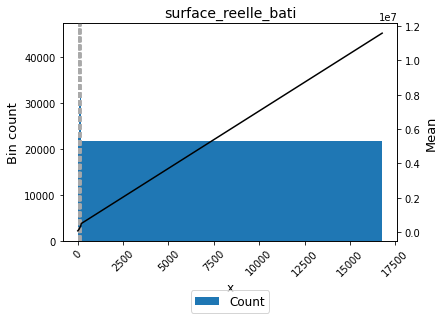

In [45]:
binning_table.plot()

In [ ]:
test=df[df['clean_code_departement']==33]

In [ ]:
y = test['Valeur fonciere']
X = test.drop(['Valeur fonciere'], axis = 1)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X,
                                                            y,
                                                            test_size=0.33,
                                                            random_state=42)

In [ ]:
df["clean_code_commune"].value_counts()[df["clean_code_commune"].value_counts()<250 ]

In [ ]:
data = load_boston()

variable_names = data.feature_names
X = data.data
y = data.target

In [ ]:
variable_names = X_train.columns.values

In [ ]:
X_train.columns

In [ ]:
categorical_variables= [ "clean_code_departement",
            "clean_code_commune", "code_postal", "Dependance",
            "month"]

In [ ]:
binning_process = BinningProcess(variable_names,
                                 categorical_variables=categorical_variables)

In [ ]:
lr = Pipeline(steps=[('binning_process', binning_process),
                     ('regressor', LinearRegression())])


In [ ]:
lr.fit(X_train, y_train)

In [ ]:
y_test_predict = lr.predict(X_test)

print("MSE:      {:.3f}".format(mean_squared_error(y_test, y_test_predict)))
print("MAE:      {:.3f}".format(mean_absolute_error(y_test, y_test_predict)))
print("R2 score: {:.3f}".format(r2_score(y_test, y_test_predict)))

In [ ]:
binning_process.information(print_level=1)

In [ ]:
binning_process.splits

In [ ]:
binning_process.summary()

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
def outlier_inspect(df,
                    col,
                    min_z=1,
                    max_z=5,
                    step=0.2,
                    max_hist=None,
                    bins=50):
    fig = plt.figure(figsize=(20, 6))
    fig.suptitle(col, fontsize=16)
    plt.subplot(1, 3, 1)
    if max_hist == None:
        sns.histplot(df[col], kde=False, bins=50, color="r")
    else:
        sns.distplot(df[df[col] <= max_hist][col], kde=False, bins=50)
    plt.subplot(1, 3, 2)
    sns.boxplot(df[col])
    plt.subplot(1, 3, 3)
    z_score_inspect = outlier_zscore(df,
                                     col,
                                     min_z=min_z,
                                     max_z=max_z,
                                     step=step)
    plt.show()

In [ ]:
def outlier_zscore(df, col, min_z=1, max_z=5, step=0.1, print_list=False):
    z_scores = df["zscores"]
    threshold_list = []
    for threshold in np.arange(min_z, max_z, step):
        threshold_list.append(
            (threshold, len(np.where(z_scores > threshold)[0])))
        df_outlier = pd.DataFrame(threshold_list,
                                  columns=['threshold', 'outlier_count'])
        df_outlier['pct'] = (df_outlier.outlier_count -
                             df_outlier.outlier_count.shift(-1)
                             ) / df_outlier.outlier_count * 100
    plt.plot(df_outlier.threshold, df_outlier.outlier_count)
    best_treshold = round(df_outlier.iloc[df_outlier.pct.argmax(), 0], 2)
    outlier_limit = int(df[col].dropna().mean() + (df[col].dropna().std()) *
                        df_outlier.iloc[df_outlier.pct.argmax(), 0])
    percentile_threshold = stats.percentileofscore(df[col].dropna(),
                                                   outlier_limit)
    plt.vlines(best_treshold,
               0,
               df_outlier.outlier_count.max(),
               colors="r",
               ls=":")
    plt.annotate(
        "Zscore : {}\nValue : {}\nPercentile : {}".format(
            best_treshold, outlier_limit,
            (np.round(percentile_threshold,
                      3), np.round(100 - percentile_threshold, 3))),
        (best_treshold, df_outlier.outlier_count.max() / 2))
    #plt.show()
    if print_list:
        print(df_outlier)
    return (plt, df_outlier, best_treshold, outlier_limit,
            percentile_threshold)


In [ ]:
outlier_inspect(df, 'Valeur fonciere')

In [ ]:
# absolute value of zscore and if sup x then 1  : 
df["outlier"] = (abs(df["zscores"])>1).astype(int)
df=df[df['outlier'] == 0].reset_index(drop=True)

##  Modele 

In [ ]:
import numpy as np
import pandas as pd
from sklearn.impute import KNNImputer

from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler


from sklearn.model_selection import cross_val_score
from sklearn.model_selection import learning_curve

from sklearn.linear_model import LinearRegression

import warnings
warnings.filterwarnings('ignore')

from sklearn import pipeline
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer

#from house_prediction_package.preprocessing import Preprocessing
#from house_prediction_package.data import GetData


class Pipeline :

    def __init__(self,df):

        # option 2
        #appeler les méthodes
        self.df = df
        self.df, self.categorical_features, self.numerical_features, self.X_train, self.X_test, self.y_train, self.y_test = Preprocessing(
            self.df).feature_generation().zscore().split_x_y()


    def pipeline(self):
        # création des pipelines de pré-processing pour les variables numériques et catégorielles
        #ajout d'un parametre pour gerer les valeures non connues dans onehotencoder - il les passe à 0(autres options disponibles)
        numerical_pipeline = make_pipeline(KNNImputer(n_neighbors=3), MinMaxScaler())
        categorical_pipeline = make_pipeline(OneHotEncoder(handle_unknown="ignore"))
        preprocessor = make_column_transformer(
            (numerical_pipeline, self.numerical_features),
            (categorical_pipeline, self.categorical_features))
        model = make_pipeline(preprocessor, LinearRegression())
        fitted_model = model.fit(self.X_train, self.y_train)
        return fitted_model, self.X_train, self.y_train,self.X_test, self.y_test


In [ ]:
def pipeline(df,X_train,y_train, numerical_features, categorical_features):
    # création des pipelines de pré-processing pour les variables numériques et catégorielles
        #ajout d'un parametre pour gerer les valeures non connues dans onehotencoder - il les passe à 0(autres options disponibles)
    numerical_pipeline = make_pipeline(KNNImputer(n_neighbors=3), MinMaxScaler())
    categorical_pipeline = make_pipeline(OneHotEncoder(handle_unknown="ignore"))
    preprocessor = make_column_transformer(
            (numerical_pipeline, numerical_features),
            (categorical_pipeline, categorical_features))
    model = make_pipeline(preprocessor, LinearRegression())
    fitted_model = model.fit(X_train, y_train)
    return fitted_model

In [ ]:
model =pipeline(df,X_train, y_train, numerical_features, categorical_features)

In [ ]:
model, X_train, y_train,X_test, y_test = Pipeline(df).pipeline()

In [ ]:
# réalisation baseline


from sklearn.impute import KNNImputer

from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import learning_curve

from sklearn.linear_model import LinearRegression

import warnings
warnings.filterwarnings('ignore')

from sklearn import pipeline
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer

In [ ]:
df = df[df['surface_carrez_lot_1'].isna() ==False]

In [ ]:
columns_model= [ 'parcelle_cad_section', 'type_de_voie',
       'code_postal', 'clean_code_departement',
       'clean_code_commune', 'surface_carrez_lot_1'
       , 'Nb_lots', 'surface_terrain',
       'surface_reelle_bati', 'nb_pieces_principales','main_type_terrain','parcelle_cadastrale','Dependance', 'Maison','Date_YYYY-MM']

In [ ]:
# a améliorer pas utile
threshold= (len(columns_model)/2)-1
for i in range(len(df.index)) :
    df.at[i,'to_drop'] = 1 if df[columns_model].iloc[i].isnull().sum() >= threshold else 0
df = df[df['to_drop']== 0].drop(['zscores','outlier','to_drop'], axis =1)

In [ ]:
# selection des variables
#j'ai viré la voie que je dois remplacer par code iris (voie trop spécifique pour apprentissage)
X = df[[ 'type_de_voie', 'code_postal', 'surface_terrain',
       'surface_reelle_bati', 'nb_pieces_principales','main_type_terrain','Dependance', 'Date_YYYY-MM']]

y =df['Valeur fonciere']

In [ ]:
X['code_postal']=X['code_postal'].astype('str')
X['clean_code_commune']=X['clean_code_commune'].astype('str')
X["Date_YYYY_MM"]=X["Date_YYYY-MM"].apply(str)
X= X.drop('Date_YYYY-MM',axis=1)

In [ ]:
# Séparation des variables catégorielles et numériques
categorical_features = X.select_dtypes(include = ['object']).columns
numerical_features = X._get_numeric_data().columns

In [ ]:
for column in categorical_features : 
    X[column]= X[column].replace(np.nan, '', regex=True)

In [ ]:
for column in categorical_features : 
    print(X[column].isnull().value_counts())

In [ ]:
# check types of entries inside df columns : 
for column in df.columns : 
    print(df[column].map(type).value_counts())

In [ ]:
# à garder et commencer par ça 
columns_ob = ["B_T_Q","type_de_voie","voie","type_de_voie","clean_code_departement","main_type_terrain","Dependance","Maison","Date_YYYY-MM"]
for column in columns_ob : 
    df[column]=df[column].replace(np.nan, '').apply(str)

In [ ]:
df[df["clean_code_departement"].map(type)== str]

In [ ]:
df= df[df["Valeur fonciere"].map(type)== str]

In [ ]:
df[df['type_de_voie'].map(type) != str] 

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [ ]:
# création des pipelines de pré-processing pour les variables numériques et catégorielles
#ajout d'un parametre pour gerer les valeures non connues dans onehotencoder - il les passe à 0(autres options disponibles)
numerical_pipeline = make_pipeline(KNNImputer(n_neighbors=3), MinMaxScaler())
categorical_pipeline = make_pipeline(OneHotEncoder(handle_unknown='ignore'))

In [ ]:
preprocessor = make_column_transformer(
    (numerical_pipeline, numerical_features), (categorical_pipeline, categorical_features))

In [ ]:
model = make_pipeline(preprocessor, LinearRegression())

In [ ]:
model.fit(X_train, y_train)

In [ ]:
model.score(X_test,y_test)

In [ ]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

test_y_hat = model.predict(X_test)
print('Score r²: ', model.score(X_test, y_test))
print("Mean absolute error: %.2f" % np.mean(np.absolute(test_y_hat - y_test)))
print("Residual  of squares (MSE): %.2f" % np.mean((test_y_hat - y_test)**2))
print("R2-score: %.2f" % r2_score(test_y_hat, y_test))

In [ ]:
#great code to create efficently new column based on condition s on other columns 
#can be applied withmultiple conditions passed as a list & multiple outputs - one per condition, 
#default value in select clause in case none condition met 
import numpy as np
conditions = [
  np.logical_and(df['Dependance']=='Maison', (df['Maison'].isnull()))
]
outputs = ['Maison']
df['Maison'] = pd.Series(np.select(conditions, outputs, 'Maison'))

In [ ]:
df['Dependance']= [value.replace('Maison','') for value in df['Dependance']]
df['Maison'] = 1


In [ ]:
df['Dependance']= [1 if value =='Dépendance'else 0 for value in df['Dependance']]

# feature importance

In [ ]:
df_filtered = df[(df['parcelle_cadastrale']== '01289000AC0176') | (df['parcelle_cadastrale']== '013500000C1248')| (df['parcelle_cadastrale']== '01195000AD0050')|(df['parcelle_cadastrale'] == '013500000C1248')| (df['parcelle_cadastrale'] == '01344000AC0181') |(df.index.isin([71,72,73,74]))]

In [ ]:
pd.set_option('display.max_columns', None)

In [ ]:
# si group by parcelle_cad_section et date et valeur fonciere alors même transaction 
#ensuite agrégats différent en fonction 
# si superficie surface reelle bati diff alors plusieurs maisons 
si value_count type local superieur à 1 alors différents locaux 
    agregats suivants : 
        somme surface reelle bati 
        somme nb pieces principales 
        si meme parcelle cadastrale alors max surface terain
        sinon somme surface terrain 
si value_count type local == 1 et que value_count nature culture superieur à 1 alors 
    agregats suviants 
        max surface reelle bati
        max nb pieces principales 
        somme surface terrain 
si value_count type local == 1 et que value_count surface reelle bati superieur à 1 alors :
    agregats suivants 
        somme surface reelle bati
        somme pieces principales 
        max surface terrain 
        
créer une colonne par type local 
     y positionner les value counts de type local 

In [ ]:
#utilisation de dask df pr optimiser le process car on va ajouter les dépendancess 
#find relative frequency of each team name in DataFrame
df.groupby('team').apply(lambda x: x['team'].count() / df.shape[0])

Pour répondre à la problématique d'affichage suivante dansle fichier dvf : 
"Quand une disposition comporte plusieurs locaux ou plusieurs natures de culture, le fichier de restitution comporte autant de lignes qu’il y a de locaux ou de nature de culture concernés par la mutation.

Ainsi, pour une même publication, il peut y avoir 1 à n ligne(s) de restitution. Les données génériques (ainsi que le prix) sont alors répétées sur chaque ligne. 

Cas particulier : dans le cas où n locaux sont construits sur un terrain comportant p natures de cultures différentes, le fichier de restitution comportera (n x p) lignes. En effet, dans ce cas, il n’est pas possible de ventiler automatiquement les locaux par nature de culture, alors le fichier présente toutes les combinaisons possibles.

Par exemple, si 2 locaux L1 et L2 sont construits sur une parcelle comportant 2 natures de culture N1 et N2 (sol et jardin), alors il y aura 4 lignes :
* L1 – N1
* L2 – N2
* L1 – N2
* L2 – N1"

Nous avons opéré en plusieurs étapes :
1. la premiere recréer les pacerelles cadastrales
 
2. la seconde créer des agrégats conditionnés avec des fonctions lambdas. la complexité de l'agrégation réside dans le fait que les aggrégations différent par variable et la typologie d'aggrégation de certaines variables dépendra des données présentes dans d'autres colonnes. si 2 lignes avec une maison mais sur deux terrains, on doit prendre la valeur de superficie de la maison sans la sommer et additionner les superficies terrains. toutefois certaines transactions auront plusieurs maisons et dans ce cas, il faut additionner les superficies maisons.

Les possibilités techniques qui s'offrent à nous sont : 
  *  apply -- Apply function func group-wise and combine the results together.
  *  aggregate -- Apply aggregate function to the GroupBy object.
  *  pipe --    Apply function to the full GroupBy object instead of to each group.
  *  transform -- Apply function column-by-column to the GroupBy object.
  
  Ensuite on drop les dépendances vendues seules (sans maison) 



In [ ]:
#preprocessing droping rows with non numeric values in 
new_df['Type local'] = new_df['Type local'].replace(np.nan, 'Non_spécifié')
new_df= new_df.drop_duplicates()

In [ ]:
# pre processing avant groupby mais attention sortir valeures foncieres avant de mettre en POO
ob_columns= df.dtypes[df.dtypes == 'O'].index
for column in ob_columns : 
    df[column]=df[column].replace(np.nan,'',regex=True)

In [ ]:
df

In [ ]:
df[['Surface terrain','Surface reelle bati','Nombre pieces principales','Surface Carrez du 1er lot']]=df[['Surface terrain','Surface reelle bati','Nombre pieces principales','Surface Carrez du 1er lot']].apply(pd.to_numeric,errors='coerce')

In [ ]:
test = df.groupby(["parcelle_cad_section","Date mutation","Valeur fonciere"], as_index= False).apply(lambda x : pd.Series({
    'B_T_Q' : x['B/T/Q'].max()
    ,'type_de_voie': x['Type de voie'].max()
    ,'voie': x['Voie'].max()
    ,'code_postal': x['Code postal'].max()
    ,'commune': max(x['Commune'])
    ,'clean_code_departement': x['clean_code_departement'].max()
    ,'clean_code_commune': max(x['clean_code_commune'])
    ,'surface_carrez_lot_1' :  x['Surface Carrez du 1er lot'].sum()/(x['Surface reelle bati'].count()/(x['Surface reelle bati'].count()/x['Nature culture'].nunique()))
    ,'Nb_lots': x[('Nombre de lots')].max()
   # ,'v1Surface reelle bati' : x['Surface reelle bati'].max() if x['Type local'].nunique() == 1 and x['Nature culture'].nunique() >1 else x['Surface reelle bati'].sum()
   # ,'v1Nombre pieces principales' : x['Nombre pieces principales'].max() if x['Type local'].nunique() == 1 and x['Nature culture'].nunique() >1 else x['Nombre pieces principales'].sum()
   # ,'v1Surface terrain': x['Surface terrain'].max() if x['Nature culture'].nunique() == 1 or x['parcelle_cadastrale'].nunique() >1 else x['Surface terrain'].sum()
    ,'surface_terrain' : x['Surface terrain'].sum()/(x['Surface terrain'].count()/x['Surface terrain'].nunique()) if int(x['Surface terrain'].nunique()) > 1 and int(x['Nature culture'].nunique()) >1 else x['Surface terrain'].max()
   # ,'v2nb_pieces':  x['Nombre pieces principales'].sum()/(x['Nombre pieces principales'].count()/x['Surface reelle bati'].nunique()) if x['Surface reelle bati'].nunique() > 1 else x['Nombre pieces principales'].max()
   # ,'v2_surface bati' :x['Surface reelle bati'].sum()/(x['Surface reelle bati'].count()/x['Surface reelle bati'].nunique()) if x['Surface reelle bati'].nunique() > 1 else x['Surface reelle bati'].max()
    ,'surface_reelle_bati' : x['Surface reelle bati'].sum()/(x['Surface reelle bati'].count()/(x['Surface reelle bati'].count()/x['Nature culture'].nunique())) 
    ,'nb_pieces_principales' : x['Nombre pieces principales'].sum()/(x['Nombre pieces principales'].count()/(x['Surface reelle bati'].count()/x['Nature culture'].nunique())) 
    ,'dependance' : x['Type local'].unique()
    ,'main_type_terrain' : x['Nature culture'].max()
}))

In [ ]:
df[df['parcelle_cad_section']=='01001000ZH']

In [ ]:
test

In [ ]:
test.dependance.unique()

In [ ]:
df=df[df.dependance.apply(lambda x: x != "['Dépendance']")]

In [ ]:
df= pd.read_csv("aggregatedfile.csv")

In [ ]:
df

In [ ]:
test = df_filtered.groupby(["parcelle_cad_section","Date mutation","Valeur fonciere"], as_index= False).apply(lambda x : pd.Series({
    'Code postal': x['Code postal'].max()
    ,'Commune': max(x['Commune'])
    ,'Surface Carrez du 1er lot' : max(x['Surface Carrez du 1er lot']) if x['Type local'].nunique() == 1 and x['Nature culture'].nunique() >1 else x['Surface Carrez du 1er lot'].sum()
    ,'Nombre de lots': x[('Nombre de lots')].max()
    ,'Surface reelle bati' : x['Surface reelle bati'].max() if x['Type local'].nunique() == 1 and x['Nature culture'].nunique() >1 else x['Surface reelle bati'].sum()
    ,'Nombre pieces principales' : x['Nombre pieces principales'].max() if x['Type local'].nunique() == 1 and x['Nature culture'].nunique() >1 else x['Nombre pieces principales'].sum()
    ,'Surface terrain': x['Surface terrain'].max() if x['Nature culture'].nunique() == 1 or x['parcelle_cadastrale'].nunique() >1 else x['Surface terrain'].sum()
    ,'v2' : x['Surface terrain'].sum()/(x['Surface terrain'].count()/x['Surface terrain'].nunique()) if x['Surface terrain'].nunique() > 1 and x['Nature culture'].nunique() >1 else x['Surface terrain'].max()
    ,'v2nb_pieces':  x['Nombre pieces principales'].sum()/(x['Nombre pieces principales'].count()/x['Surface reelle bati'].nunique()) if x['Surface reelle bati'].nunique() > 1 else x['Nombre pieces principales'].max()
    ,'v2_surface bati' :x['Surface reelle bati'].sum()/(x['Surface reelle bati'].count()/x['Surface reelle bati'].nunique()) if x['Surface reelle bati'].nunique() > 1 else x['Surface reelle bati'].max()
    ,'v3_surface_bati' : x['Surface reelle bati'].sum()/(x['Surface reelle bati'].count()/(x['Surface reelle bati'].count()/x['Nature culture'].nunique())) 
    ,'v3_nb_pieces' : x['Nombre pieces principales'].sum()/(x['Nombre pieces principales'].count()/(x['Surface reelle bati'].count()/x['Nature culture'].nunique())) 
    ,'Type local': x['Type local'].nunique()
    ,'Nature culture' : x['Nature culture'].nunique()
    ,'test' : x['Nature culture'].count()
}))

In [ ]:
# même maison surface reelle bati identique 
df[(df['parcelle_cadastrale'] == '013500000C1248')]
#actions possibles : 
# meme valeur fonciere 
# meêm type local 
# même surface relle bati
 #pas d'info sur 1er lot
# pas d info Nombre de lots 
# même nombre de pieces principales

# différence nature culture (variable texte )
# surface terrain différente en fonction de la parcelle cadastrale 


In [ ]:
# cas ou type local identique mais nature culture différente: 

df[(df['parcelle_cadastrale']== '01289000AC0176') | (df['parcelle_cadastrale']== '013500000C1248')| (df['parcelle_cadastrale']== '01195000AD0050')]
#actions possibles : 
# meme valeur fonciere 
# meme de surface reelle bati 
#pas d'info sur 1er lot
# pas d info Nombre de lots 
#meme nombre pieces principales 
# différente nature culture (variable texte )
# différente surface terrain 


In [ ]:
# cas ou 2 maisons , une dépendance et un terrain :
# repérable par section et date commune 


df[df.index.isin([71,72,73,74])]
#actions possibles : 
# meme valeur fonciere 
# code type lcoal différent pr dépendance absent pour terrain
# différence de surface reelle bati  (0 dépendance et nan pour terrain)
#pas d'info sur 1er lot
# pas d info Nombre de lots 
# différence sur nombre de pieces principales

# différence nature culture (variable texte )
# surface terrain différente en fonction de la parcelle cadastrale 


In [ ]:
test=df_filtered.groupby(["parcelle_cad_section","Date mutation","Valeur fonciere"], as_index= False).agg({
    'Code postal': 'max'
    ,'Commune': 'max'
    ,'Surface Carrez du 1er lot' : lambda x : x.max() if df_filtered['Type local'].nunique() == 1 and df_filtered['Nature culture'].nunique() >1 else x.sum()
    ,'Nombre de lots': 'max'
    ,'Surface reelle bati' : lambda x : x.max() if ['Type local'].nunique() == 1 and ['Nature culture'].nunique() >1 else x.sum()
    ,'Nombre pieces principales' : lambda x : x.max() if df_filtered['Type local'].nunique() == 1 and df_filtered['Nature culture'].nunique() >1 else x.sum()
    ,'Surface terrain' : lambda x : x.max() if df_filtered['Nature culture'].nunique() == 1 or df_filtered['parcelle_cadastrale'].nunique() >1 else x.sum()
    ,'Type local': lambda x: x.value_counts().index[0]
    ,'clean_code_departement' : lambda x: x.value_counts().index[0]
    ,'clean_code_commune' : lambda x: x.value_counts().index[0]
    ,'Nature culture' : 'nunique'
    ,'Nature mutation' : 'count'})


In [ ]:
 
df_filtered[(df_filtered['parcelle_cadastrale'] == '01289000AC0176')].groupby(["parcelle_cad_section","Date mutation","Valeur fonciere"], as_index= False).agg({
    'Type local':lambda x : x.nunique()
    ,'Nombre pieces principales' : lambda x : x.max() if prout['Type local'].nunique() == 1 and prout['Nature culture'].nunique() >1 else x.sum()
    ,'Nature culture':lambda x : x.nunique()})
    


In [ ]:
# convert the 'Date' column to datetime format \n
df_maison['Date mutation']= pd.to_datetime(df_maison['Date mutation'],format= "%d/%m/%Y")
#df_maison= df_maison.drop(['Date mutation'], axis = 1)

In [ ]:
df_maison.columns

In [ ]:
# supression des colonnes innutiles avant chargement dans db 
df_maison=df_maison.drop(['Code service CH', 'Reference document', '1 Articles CGI',
'2 Articles CGI', '3 Articles CGI', '4 Articles CGI', '5 Articles CGI','No Volume','Identifiant local'], axis =1 )

## Performances

On a des problemes de performances 1h pr ingérer 1/25 des données brutes. 2 MIllions de lignes et plus de 30 colonnes
avant d'envoyer en base, on va essayer de nettoyer le df (suppression des colonnes inutiles, des doublons, des lignes vides)
regroupement des lignes correspondant à 1 seule transaction- création d'un id et group by 
recentrer le projet sur les mventes de maisons

In [ ]:
## à vérifier si cela fonctionne
engine = create_engine('sqlite:///../data/transactions.sqlite', echo = True)
Session = sessionmaker(bind=engine)
Base = declarative_base()

In [ ]:
# à corriger en reprenant typo de l'exercice foot
class Transactions_maisons(Base):
        __tablename__ = 'dvf_maisons'

        id = Column(Integer, primary_key=True)
        no_disposition = Column(Integer)
        date_mutation = Column(Date)
        nature_mutation = Column(String)
        valeur_fonciere = Column(Integer)
        no_voie = Column(Integer)
        b_t_q = Column(String)
        type_voie = Column(String)
        code_voie = Column(String)
        voie = Column(String)
        code_postal = Column(Integer)
        commune = Column(String)
        code_departement = Column(String)
        code_commune = Column(String)
        prefixe_section = Column(String)
        section = Column(String)
        no_plan = Column(Integer)
        lot_1 = Column(String)
        surface_carrez_1er_lot = Column(Integer)
        lot_2 = Column(String)
        surface_carrez_2eme_lot = Column(Integer)
        lot_3 = Column(String)
        surface_carrez_3eme_lot = Column(Integer)
        lot_4 = Column(String)
        surface_carrez_4eme_lot = Column(Integer)
        lot_5 = Column(String)
        surface_carrez_5eme_lot = Column(Integer)
        nombre_lots = Column(Integer)
        code_type_local = Column(Float)
        type_local = Column(String)
        surface_reelle_bati = Column(Integer)
        nombre_pieces_principales = Column(Integer)
        nature_culture = Column(String)
        nature_culture_speciale = Column(String)
        surface_terrain = Column(Integer)
        
        def __init__(self, no_disposition, date_mutation, nature_mutation, valeur_fonciere, no_voie,
                     b_t_q, type_voie, code_voie, voie, code_postal, commune, code_departement, 
                     code_commune, prefixe_section, section, no_plan, lot_1, surface_carrez_1er_lot, 
                     surface_carrez_2eme_lot, surface_carrez_3eme_lot, surface_carrez_4eme_lot, 
                     surface_carrez_5eme_lot, lot_2, lot_3, lot_4, lot_5, nombre_lots, code_type_local, 
                     type_local, surface_reelle_bati, nombre_pieces_principales, nature_culture, nature_culture_speciale,
                     surface_terrain ):
            self.no_disposition = no_disposition 
            self.date_mutation = date_mutation 
            self.nature_mutation = nature_mutation
            self.valeur_fonciere = valeur_fonciere 
            self.no_voie = no_voie
            self.b_t_q = b_t_q 
            self.type_voie = type_voie 
            self.code_voie = code_voie 
            self.voie = voie 
            self.code_postal = code_postal
            self.commune = commune
            self.code_departement = code_departement
            self.code_commune = code_commune
            self.prefixe_section = prefixe_section
            self.section = section
            self.no_plan = no_plan
            self.lot_1 = lot_1
            self.surface_carrez_1er_lot = surface_carrez_1er_lot
            self.lot_2 = lot_2
            self.surface_carrez_2eme_lot = surface_carrez_2eme_lot
            self.lot_3 = lot_3
            self.surface_carrez_3eme_lot = surface_carrez_3eme_lot
            self.lot_4 = lot_4
            self.surface_carrez_4eme_lot = surface_carrez_4eme_lot
            self.lot_5 = lot_5
            self.surface_carrez_5eme_lot = surface_carrez_5eme_lot
            self.nombre_lots = nombre_lots
            self.code_type_local = code_type_local
            self.type_local = type_local
            self.surface_reelle_bati = surface_reelle_bati
            self.nombre_pieces_principales = nombre_pieces_principales
            self.nature_culture = nature_culture
            self.nature_culture_speciale = nature_culture_speciale
            self.surface_terrain =surface_terrain 

In [ ]:
# delete table
#Transactions_maisons.__table__.drop(engine)"

In [ ]:
# 2 - generate database schema
Base.metadata.create_all(engine)
# 3 - create a new session
session = Session()

In [ ]:
n = 2000  #chunk row size
list_df = [df_maison[i:i+n] for i in range(0,df_maison.shape[0],n)]
# reassemblage by pd.concat possible mais on s'en fiche car on va fonctionner sur des'petits df' 
#pour enrichissement puis insertion en bdd

In [ ]:
test = 'ok'
start_time = datetime.now()
for j in range(len(list_df)):
    if test == 'ok':
        for i,transaction in list_df[j].iterrows():
            session= Session()
            new_transaction = Transactions_maisons(transaction.values[0],transaction.values[1],transaction.values[2],transaction.values[3],transaction.values[4],
                                                      transaction.values[5],transaction.values[6],transaction.values[7],transaction.values[8],transaction.values[9],
                                                      transaction.values[10],transaction.values[11],transaction.values[12],transaction.values[13],transaction.values[14],
                                                      transaction.values[15],transaction.values[16],transaction.values[17],transaction.values[18],transaction.values[19],
                                                      transaction.values[20],transaction.values[21],transaction.values[22],transaction.values[23],transaction.values[24],
                                                      transaction.values[25],transaction.values[26],transaction.values[27],transaction.values[28],transaction.values[29],
                                                      transaction.values[30],transaction.values[31],transaction.values[32],transaction.values[33])
            session.add(new_transaction)
            session.commit()
            session.close()
    else  :
        break
    test= input(f"iteration {j}, pour passer à l'itération {j+1} taper ok  : ")
end_time = datetime.now()
print('Duration: {}'.format(end_time - start_time))

In [ ]:
#integré à la boucle 
#session.commit()
session.close()

In [ ]:
session = Session()

In [ ]:
rows = session.query(Transactions_maisons).count()
rows